In [ ]:
!pip install xgboost scikit-learn pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.4 MB/s eta 0:00:00a 0:00:01


### Import packages and Data

In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

In [7]:
# Load the data
df = pd.read_csv('data/data_imputed.csv', index_col=['id', 'time'])
df

,,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
id,time,,,,,,,,,,,,,,,,,,,
AS14.08,2014-03-13,0.000000,14.101000,47.864667,0.000000,0.0,0.0,0.000000,26.106875,33.491833,0.000000,0.000000,13.062000,0.000000,0.0,0.000000,0.60,6.60,55.066533,1.0
AS14.13,2014-03-13,0.000000,7.169667,46.672273,36.754000,0.0,0.0,0.000000,46.723600,174.092000,0.000000,0.000000,13.062000,0.000000,1.0,-2.000000,1.00,7.00,83.482467,1.0
AS14.16,2014-03-13,0.000000,4.913900,30.734167,36.754000,0.0,0.0,0.000000,36.415238,103.791917,0.000000,0.000000,13.062000,0.000000,1.0,-0.500000,1.50,8.00,22.923222,1.0
AS14.17,2014-03-13,0.000000,8.728189,41.757035,36.754000,0.0,0.0,0.000000,36.415238,103.791917,0.000000,0.000000,13.062000,0.000000,1.0,0.750000,0.75,7.25,53.824074,1.0
AS14.05,2014-03-14,0.000000,15.121824,49.573057,4.144754,0.0,0.0,0.000000,44.801875,58.581125,0.000000,0.000000,9.552333,0.000000,1.0,-1.000000,2.00,8.00,63.892159,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AS14.26,2014-05-29,0.028571,3.106714,18.806000,58.141857,0.0,0.0,44.738625,3.524500,62.085461,64.460083,0.000000,5.111000,15.360083,1.0,0.000000,0.80,7.40,64.947000,1.0
AS14.33,2014-05-29,0.169354,6.452161,54.388125,68.369000,0.0,0.0,44.738625,9.734000,198.880222,0.939000,0.000000,1.599500,15.360083,1.0,-1.333333,1.00,7.00,118.978033,1.0
AS14.24,2014-05-30,0.035684,8.586340,56.645530,56.138286,0.0,0.0,44.738625,9.038200,19.399769,0.939000,0.000000,2.519500,0.000000,1.0,0.200000,1.20,7.40,98.698707,1.0


### Prepare Data for Feature Selection

In [8]:
df.reset_index(inplace=True)
df['time'] = pd.to_datetime(df['time'])

# Shift the 'mood' column up to represent the next day's mood
df['mood_next_day'] = df.groupby('id')['mood'].shift(-1)

# Drop rows with any missing target value
df.dropna(subset=['mood_next_day'], inplace=True)

# Define features and target
X = df.drop(['mood_next_day', 'id', 'time', 'mood'], axis=1)  # Drop non-feature columns and the target
y = df['mood_next_day']

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### XGBoost

In [9]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# predictions = model.predict(X_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

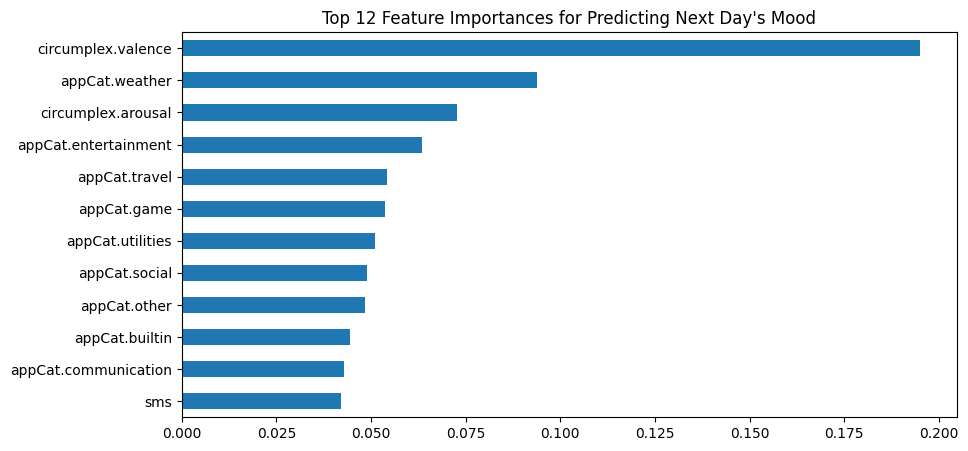

In [43]:
features_xgb = pd.Series(model.feature_importances_, index=X.columns)

# Sort the feature importances in descending order and take the top 10
features_xgb = features_xgb.sort_values(ascending=False).head(12)
features_xgb.plot(kind='barh', figsize=(10, 5))  # Set figsize accordingly

plt.title("Top 12 Feature Importances for Predicting Next Day's Mood")
plt.gca().invert_yaxis()  # To display the highest importance at the top of the plot
plt.show()


### LASSO (L1 regularization)

In [29]:
# Fit Lasso model
lasso = Lasso()
parameters = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)
best_lasso = lasso_regressor.best_estimator_
y_pred = best_lasso.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))

# Print the best alpha and RMSE
best_alpha = lasso_regressor.best_params_['alpha']
print(f"Best alpha: {best_alpha}")
print(f"Test RMSE: {rmse}")

Best alpha: 0.01
Test RMSE: 0.7565617650210363


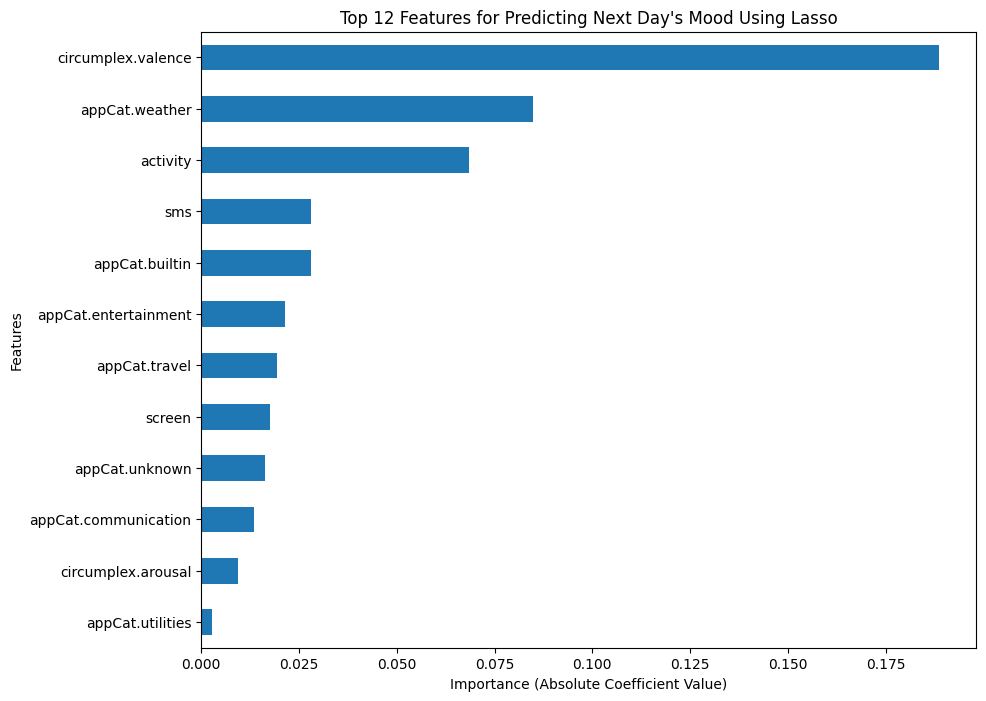

In [42]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

features_lasso = pd.Series(lasso.coef_, index=X.columns)
features_lasso = features_lasso.abs().sort_values(ascending=True)  # Sort in ascending for horizontal plot
features_lasso = features_lasso[features_lasso != 0][-12:]

# Plot top features horizontally
features_lasso.plot(kind='barh', figsize=(10, 8))  # Adjust figure size as needed
plt.title('Top 12 Features for Predicting Next Day\'s Mood Using Lasso')
plt.xlabel('Importance (Absolute Coefficient Value)')
plt.ylabel('Features')
plt.show()


### Ridge (L2 regularization)

In [28]:
ridge = Ridge(random_state=42)
parameters = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)

ridge_regressor.fit(X_train, y_train)
best_ridge = ridge_regressor.best_estimator_
y_pred = best_ridge.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))

# Print the best alpha and RMSE
best_alpha = ridge_regressor.best_params_['alpha']
print(f"Best alpha: {best_alpha}")
print(f"Test RMSE: {rmse}")

Best alpha: 100
Test RMSE: 0.7571369259686296


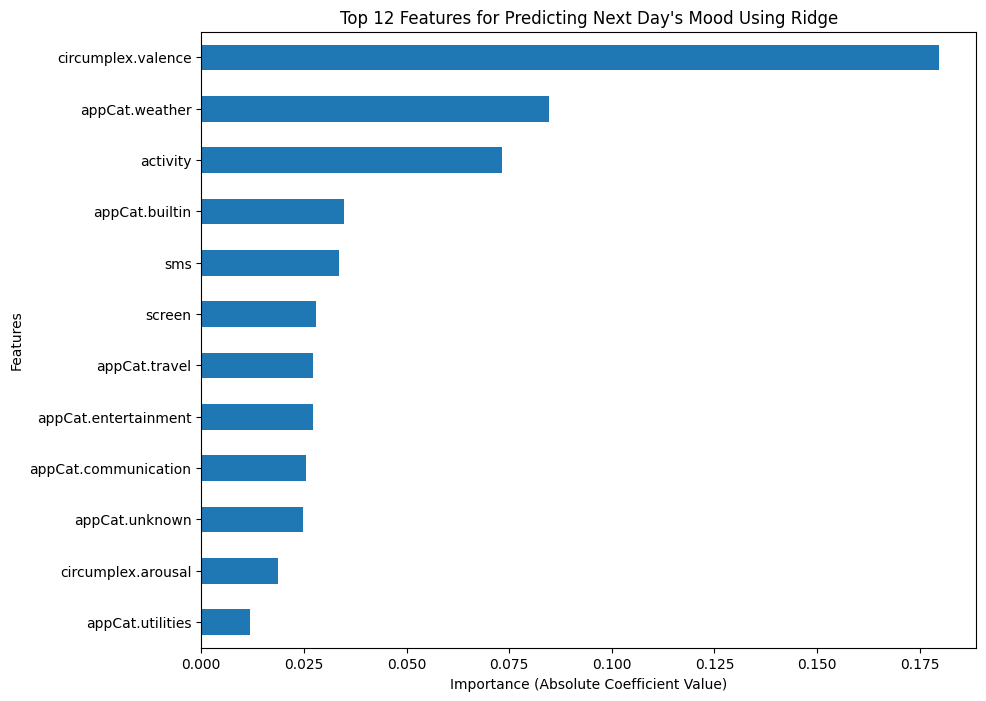

In [41]:
ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train)

features_ridge = pd.Series(ridge.coef_, index=X.columns)
features_ridge = features_ridge.abs().sort_values(ascending=True)  # Sort in ascending for horizontal plot
features_ridge = features_ridge[features_ridge != 0][-12:]

# Plot top features horizontally
features_ridge.plot(kind='barh', figsize=(10, 8))  # Adjust figure size as needed
plt.title('Top 12 Features for Predicting Next Day\'s Mood Using Ridge')
plt.xlabel('Importance (Absolute Coefficient Value)')
plt.ylabel('Features')
plt.show()

### Final list of features

In [50]:
from collections import Counter
all_features = list(features_xgb.keys()) + list(features_lasso.keys()) + list(features_ridge.keys())
feature_counts = Counter(all_features)
final_features = [feature for feature, count in feature_counts.items() if count >= 2]
final_features


['circumplex.valence',
 'appCat.weather',
 'circumplex.arousal',
 'appCat.entertainment',
 'appCat.travel',
 'appCat.utilities',
 'appCat.builtin',
 'appCat.communication',
 'sms',
 'appCat.unknown',
 'screen',
 'activity']

In [49]:
features_3 = [feature for feature, count in feature_counts.items() if count >= 3]
features_3

['circumplex.valence',
 'appCat.weather',
 'circumplex.arousal',
 'appCat.entertainment',
 'appCat.travel',
 'appCat.utilities',
 'appCat.builtin',
 'appCat.communication',
 'sms']

### Check correlations

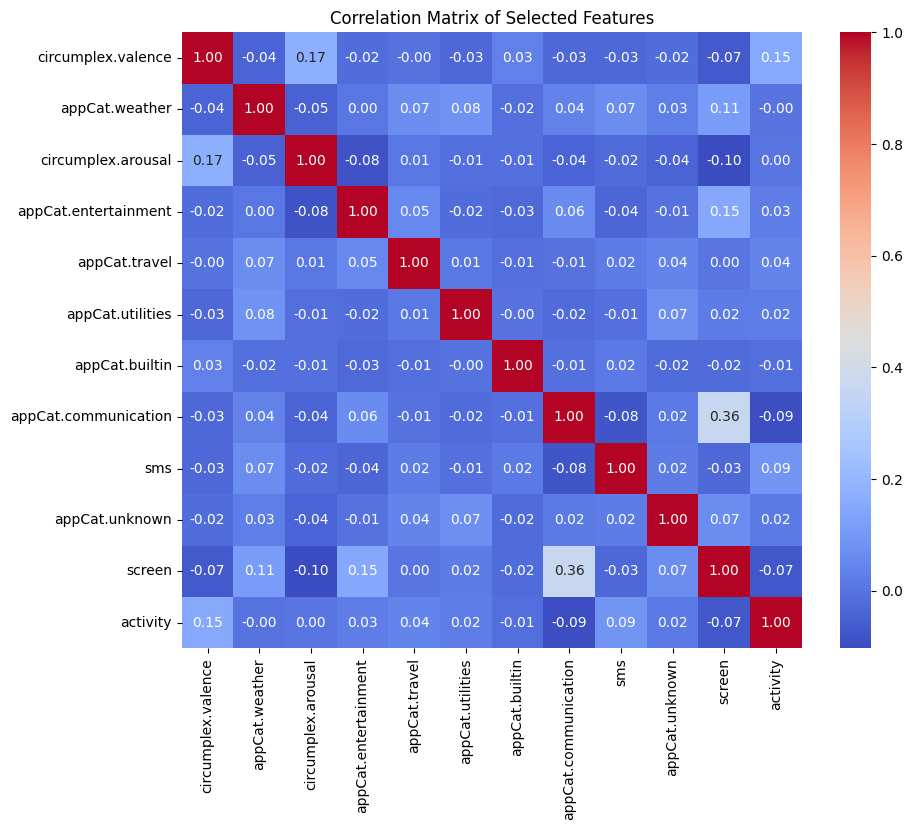

In [46]:
filtered_df = df[final_features]
correlation_matrix = filtered_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Selected Features')
plt.show()


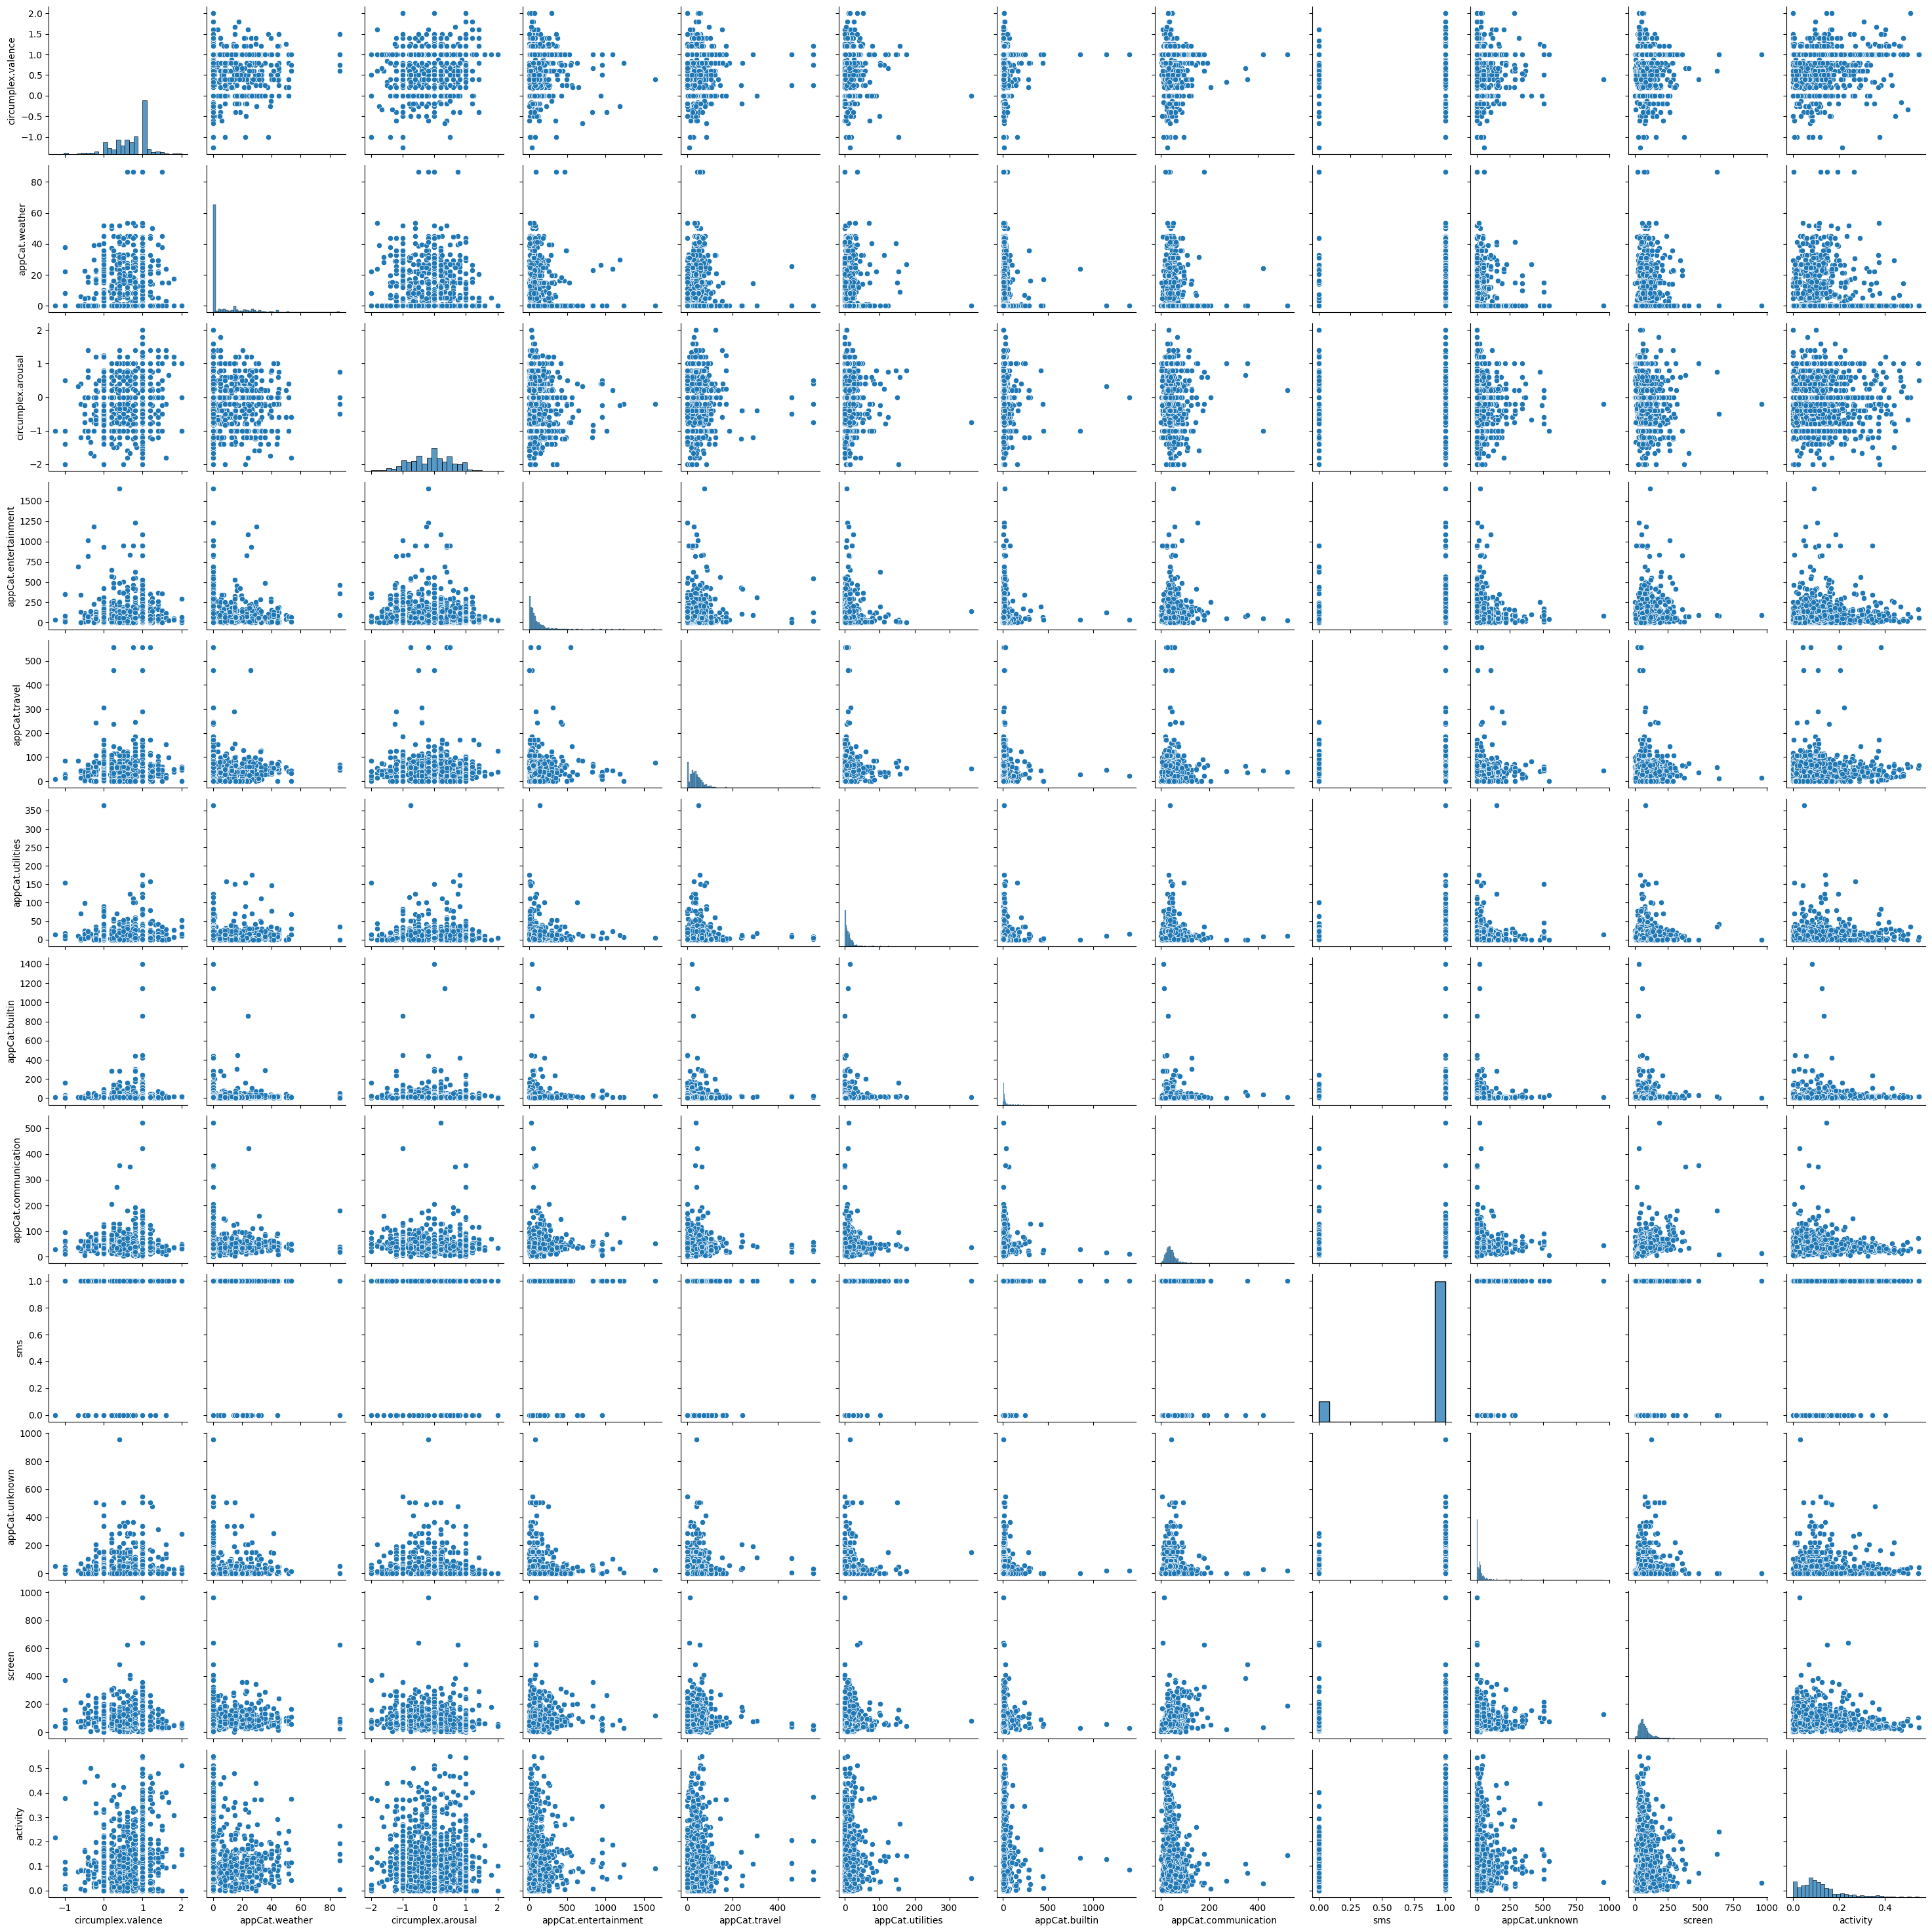

In [47]:
sns.pairplot(filtered_df)
plt.show()

Since we don't know what unknown has, we remove it from the model even though it has high predictive power.